In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from networkx import DiGraph

### Generating Data


In [2]:
class DataGenerator():
    def __init__(self, n_stages=6,  n_ways=4, n_users=10, size=100):
        self.df = None      
        self.n_stages = n_stages
        self.n_ways = n_ways
        self.n_users = n_users
        self.size = size
    
    def make_df(self):
        df_len = self.n_ways * self.size
        data = pd.DataFrame(np.arange(df_len), columns=['id'])
        data['stages'] = [0] * df_len
        data['user'] = np.random.randint(0, self.n_users, df_len)
        ways = []
       

        # creating random ways
        while len(ways) != self.n_ways:
            way = [1] # start
            way_len = np.random.randint(2, self.n_stages)
            for _ in range(way_len):
                stage = np.random.randint(2, self.n_stages)
                way.append(stage)
            way.append(self.n_stages)
            way = pd.unique(way).tolist()
            if way not in ways and len(way) > 2:
                ways.append(way)                
        ways = np.repeat(ways, self.size)
        data['stages'] = ways            
        self.df = data
        return self    
    
    def expand(self):
        data = self.df
        data = data.explode('stages')
        data['stages'] = data['stages'].astype(str)
        data['from'] = data.groupby(['id'])['stages'].shift(1)       
        self.df = data
        return data        

### implementing Graph class

In [3]:
class Graph():
    def __init__(self, df, id_col, stage_col, user_col):
        self.df = df
        self.id_col = id_col
        self.user_col = user_col
        self.stage_col = stage_col
        self.stages = self.df[self.stage_col].unique()
        self.act_graph = None
        self.usr_graph = None
        
    def create_activities_graph(self):
        stages = self.df[self.stage_col].unique()
        graph = DiGraph() 
        for stage in stages:
            graph.add_node(stage)
        self.df['from'] = self.df.groupby([self.id_col])[self.stage_col].shift(1)

        edges = self.df.loc[:, ['from', self.stage_col]].drop_duplicates().dropna().values

        graph.add_edges_from(edges)
        self.act_graph = graph
        return graph

    def create_users_graph(self):
        users = self.df[self.user_col].unique()
        graph = DiGraph() 
        for user in users:
            graph.add_node(user)
        self.df['from_user'] = self.df.groupby([self.id_col])[self.user_col].shift(1)

        edges = self.df.loc[:, ['from_user', self.user_col]].drop_duplicates().dropna().values
        graph.add_edges_from(edges)
        self.usr_graph = graph
        return graph
    
    def draw_activities(self, alpha=0.03, labels=None, layout=None, info=None):

        activity_matrix = np.zeros((len(self.stages)+1, len(self.stages)+1))
        
        for _, row in self.df.iterrows():
            if(pd.isna(row['from'])):
                continue
                
            x_from = int(row['from'])
            x_stag = int(row[self.stage_col])
            activity_matrix[x_from, x_stag] += 1

        self.activity_matrix = activity_matrix
        
        graph = DiGraph()
        graph.add_nodes_from(self.act_graph.nodes)
        
        plt.figure(figsize=(16,8))
        plt.title("Граф перехода активностей")
        
        if(info=='nodes'):
            print("Всего {} видов действий".format(len(self.stages)))
        elif(info=='time'):
            print("Среднее время действия:")
            df = self.df.sort_values('datetime')
            df['datetime_shift'] = df.datetime.shift(1)
            for stage in np.unique(df[self.stage_col]):
                df_ = df.loc[df[self.stage_col]==stage]
                mean = (df_.datetime[1:] - df_.datetime_shift[1:]).mean()
                print(mean, ' - ', labels[stage])
        elif(info=='all'):
            print("Всего {} видов действий\n".format(len(self.stages)))
            print("Среднее время действия:")
            df = self.df.sort_values('datetime')
            df['datetime_shift'] = df.datetime.shift(1)
            for stage in np.unique(df[self.stage_col]):
                df_ = df.loc[df[self.stage_col]==stage]
                mean = (df_.datetime[1:] - df_.datetime_shift[1:]).mean()
                print(mean, ' - ', labels[stage])
            info='edges'
        
        
        for edge in self.act_graph.edges:
            graph.add_edge(edge[0], edge[1], weight=1 + alpha*activity_matrix[int(edge[0]), int(edge[1])])
            
        weights = [graph[u][v]['weight'] for u,v in graph.edges]
        
        if layout:
            pos = layout(graph)
        else:
            pos = None
        
        nx.draw(graph, pos=pos, width=weights, with_labels=True, font_size=20, node_size=500, 
                    node_color='c',  edge_color='b', labels=labels)
        if info=='edges':
            labels = {}
            for edge in self.act_graph.edges:
                labels[edge] = int(activity_matrix[int(edge[0]), int(edge[1])])
            nx.draw_networkx_edge_labels(graph, pos=pos, width=weights, with_labels=True, 
                                        font_size=20, node_size=500, 
                                        node_color='b',  edge_color='c', edge_labels=labels)
        plt.show()
        
    def draw_users(self, alpha=0.03, labels=None, layout=None, info=None):

        self.users = np.unique(self.df[self.user_col])
        users_matrix = np.zeros((len(self.users), len(self.users)))

        for _, row in self.df.iterrows():
            if pd.isna(row['from_user']):
                continue
            else:
                user = int(row[self.user_col])
                prev = int(row['from_user'])
                
                users_matrix[prev, user] += 1
                
        self.users_matrix = users_matrix
        
        graph = nx.DiGraph()
        graph.add_nodes_from(self.usr_graph.nodes)
        
        for edge in self.usr_graph.edges:
            if self.users_matrix[int(edge[0]), int(edge[1])] > 0:
                graph.add_edge(edge[0], edge[1], weight = 1 + alpha*self.users_matrix[int(edge[0]), int(edge[1])])
        
        plt.figure(figsize=(16,8))
        plt.title("Граф социальных связей")

        if(info=='nodes'):
            print("Всего {} пользователей".format(len(self.users)))
        elif(info=='time'):
            print("Среднее время пользователя:")
            df = self.df.sort_values('datetime')
            df['datetime_shift'] = df.datetime.shift(1)
            for user in np.unique(df[self.user_col]):
                df_ = df.loc[df[self.user_col]==user]
                mean = (df_.datetime[1:] - df_.datetime_shift[1:]).mean()
                print(mean, ' - ', labels[user])
                
        elif(info=='all'):
            print("Всего {} пользователей\n".format(len(self.users)))
            print("Среднее время пользователя:")
            df = self.df.sort_values('datetime')
            df['datetime_shift'] = df.datetime.shift(1)
            for user in np.unique(df[self.user_col]):
                df_ = df.loc[df[self.user_col]==user]
                mean = (df_.datetime[1:] - df_.datetime_shift[1:]).mean()
                print(mean, ' - ', labels[user])
            info='edges'
        
        weights = [graph[u][v]['weight'] for u,v in graph.edges]
       
        if layout:
            pos = layout(graph)
        else:
            pos = None
        nx.draw(graph, pos=pos, width=weights, with_labels=True, font_size=12, node_size=500,
                node_color='pink', edge_color='c', labels=labels)
        if info=='edges':
            lab = {}
            for edge in self.usr_graph.edges:
                if edge[0] == edge[1]:
                    continue
                lab[edge] = str(int(self.users_matrix[int(edge[0]), int(edge[1])])) + '<->' \
                + str(int(self.users_matrix[int(edge[1]), int(edge[0])]))
                
            nx.draw_networkx_edge_labels(graph, pos=pos, width=weights, with_labels=True, 
                                        font_size=12, node_size=500, 
                                        node_color='b',  edge_color='c', edge_labels=lab)
        plt.show()       

###  Generating data 

In [4]:
G = DataGenerator()
G.make_df()
G.df.head()

,id,stages,user
0,0,"[1, 2, 3, 6]",9
1,1,"[1, 2, 3, 6]",6
2,2,"[1, 2, 3, 6]",0
3,3,"[1, 2, 3, 6]",0
4,4,"[1, 2, 3, 6]",4


In [5]:
data = G.expand()
data.head()

,id,stages,user,from
0,0,1,9,NaN
0,0,2,9,1
0,0,3,9,2
0,0,6,9,3
1,1,1,6,NaN


In [6]:
# graph = Graph(data, 'id', 'stages', 'user')
# graph.create_users_graph()
# graph.draw_users(alpha=0.05)
# graph.users_matrix

In [18]:
# graph = Graph(data, 'id', 'stages', 'user')
# graph.create_activities_graph()
# graph.draw_activities()

### Using existing log

In [8]:
log = pd.read_csv("pm_data/Chapter_1/running-example.csv", sep=';')
log['datetime'] = pd.to_datetime(log["dd-MM-yyyy:HH.mm"], format='%d-%m-%Y:%H.%M')
log.drop("dd-MM-yyyy:HH.mm", axis=1, inplace=True)
log.head()

,Case ID,Event ID,Activity,Resource,Costs,datetime
0,1,35654423,register request,Pete,50,2010-12-30 11:02:00
1,1,35654424,examine thoroughly,Sue,400,2010-12-31 10:06:00
2,1,35654425,check ticket,Mike,100,2011-01-05 15:12:00
3,1,35654426,decide,Sara,200,2011-01-06 11:18:00
4,1,35654427,reject request,Pete,200,2011-01-07 14:24:00


In [9]:
log["User ID"] = log['Resource']
log['Activity ID'] = log['Activity']

act_id = dict()
id_act = dict()
usr_id = dict()
id_usr = dict()

for i, act in enumerate(np.unique(log.Activity)):
    act_id[act] = i
    id_act[i] = act

for i, usr in enumerate(np.unique(log.Resource)):
    usr_id[usr] = i
    id_usr[i] = usr

for i in range(log.shape[0]):
    log.loc[i,'User ID'] = usr_id[log.loc[i,'Resource']]
    log.loc[i,'Activity ID'] = act_id[log.loc[i,'Activity']]

In [10]:
log.head()

,Case ID,Event ID,Activity,Resource,Costs,datetime,User ID,Activity ID
0,1,35654423,register request,Pete,50,2010-12-30 11:02:00,2,5
1,1,35654424,examine thoroughly,Sue,400,2010-12-31 10:06:00,5,3
2,1,35654425,check ticket,Mike,100,2011-01-05 15:12:00,1,0
3,1,35654426,decide,Sara,200,2011-01-06 11:18:00,3,1
4,1,35654427,reject request,Pete,200,2011-01-07 14:24:00,2,7


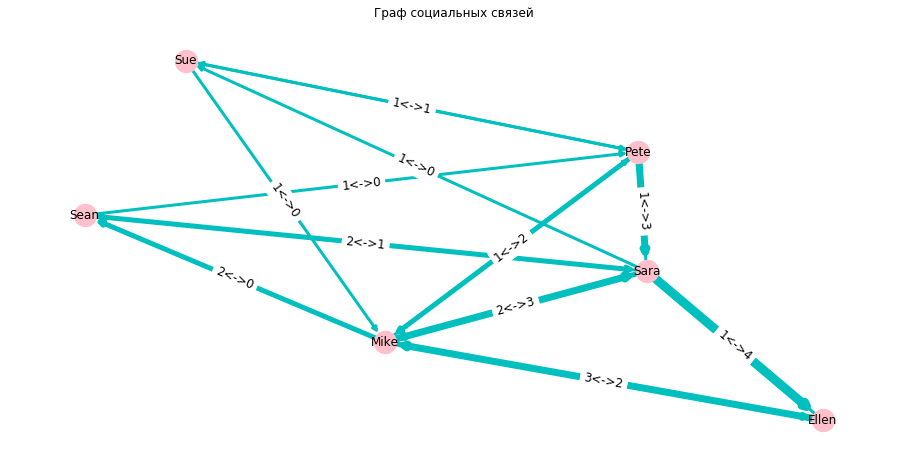

In [14]:
graph = Graph(log, 'Case ID', 'Activity ID', 'User ID')
g = graph.create_users_graph()
graph.draw_users(alpha=2, labels=id_usr, layout=nx.spring_layout, info='edges')

Среднее время пользователя:
0 days 18:17:10  -  Ellen
0 days 08:22:42  -  Mike
0 days 03:58:50  -  Pete
0 days 19:59:43.636363  -  Sara
0 days 01:43:00  -  Sean
0 days 20:18:00  -  Sue


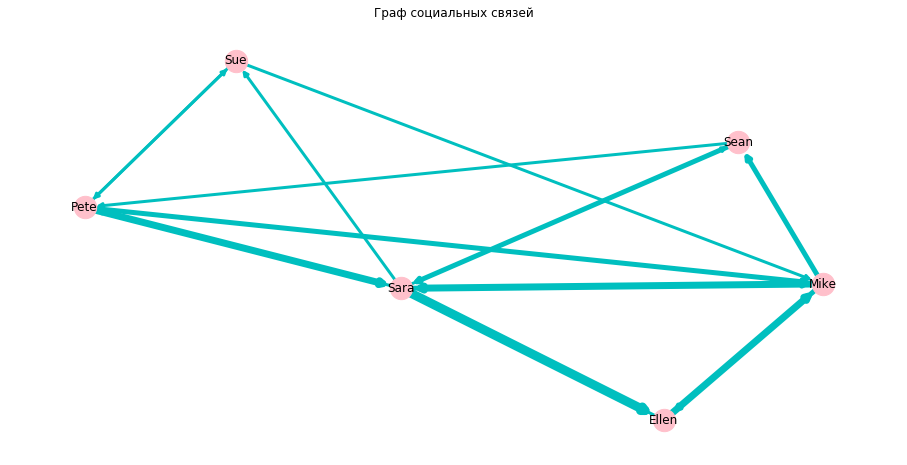

In [15]:
graph.draw_users(alpha=2, labels=id_usr, layout=nx.spring_layout, info='time')

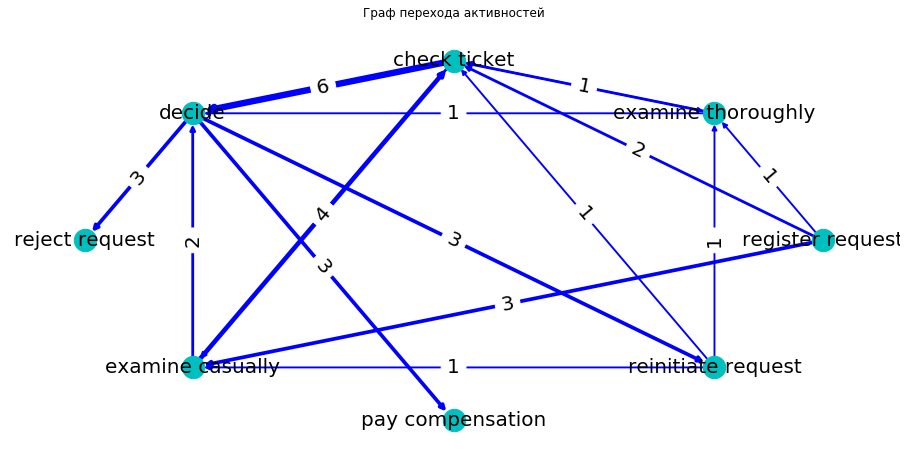

In [16]:
graph = Graph(log, 'Case ID', 'Activity ID', 'User ID')
g = graph.create_activities_graph()
graph.draw_activities(alpha=0.9, labels=id_act, layout=nx.circular_layout, info='edges')

Среднее время действия:
0 days 09:39:15  -  check ticket
0 days 20:49:37.500000  -  decide
0 days 08:49:48  -  examine casually
0 days 01:43:00  -  examine thoroughly
0 days 22:37:00  -  pay compensation
0 days 04:06:24  -  register request
1 days 02:10:00  -  reinitiate request
1 days 00:35:00  -  reject request


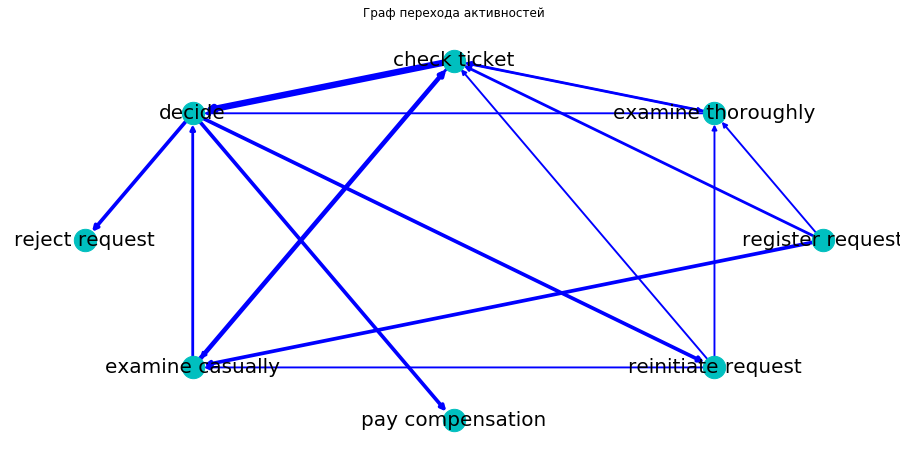

In [17]:
graph.draw_activities(alpha=0.9, labels=id_act, layout=nx.circular_layout, info='time')